# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [4]:
import pandas as pd
import os
import re
import numpy as np
import math
import json
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [6]:
# temporary variable to store merged profile and transcript data
temp = profile.merge(transcript, how='inner', left_on='id', right_on='person')

# dataframe that filters for only offers received or viewed
df = temp[(temp['event'] == 'offer received') | (temp['event'] == 'offer viewed')]
df.reset_index(drop=True, inplace=True)

In [7]:
# create new column with offer IDs
offer = []
for i in range(0, len(df)):
    x = df['value'][i]['offer id']
    offer.append(x)
    
df['offer'] = offer

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [11]:
def transform_data(df):
    
    """
    Description: 
      Transforms given data by making each row a unique combination person and offer attempt
    
    Parameters:
        df (DataFrame) - Combined dataframe containing merged data from profile.json
                        and transcript.json
    
    Output:
        final_df (DataFrame) - Transformed dataframe
    """
    
    # sort and reset index
    df.sort_values(by=['id', 'time', 'event'], ascending=[True, True, True], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # subset of columns
    df_subset = df[['person', 'event', 'offer', 'time']]
    
    offer_number = []
    
    #loop through and add offer number to person IDs
    count = 1
    for i in range(0,len(df_subset)):
        # if first row, add _1
        if i == 0:
            offer_number.append(str(df_subset['person'][i]) + '_' + str(count))
        else:
            # if new person, restart the count
            if df_subset['person'][i] != df_subset['person'][i-1]:
                count = 0
            else:
                pass
            # if offer was viewed, maintain same count; increase count by 1 for the next cycle
            if 'offer viewed' in df_subset['event'][i] and df_subset['offer'][i] != df_subset['offer'][i-1]:
                offer_number.append(str(df_subset['person'][i]) + '_' + str(count))
                count += 1
            else:
                # if new offer is received, increase count by 1
                if 'offer received' in df_subset['event'][i]:
                    count += 1
                    offer_number.append(str(df_subset['person'][i]) + '_' + str(count))
                    
                else:
                    offer_number.append(str(df_subset['person'][i]) + '_' + str(count))
                        
    df_subset['offer_number'] = offer_number
    
    print(df_subset['offer_number'].value_counts())

    # flatten -  every row is a unique offer number 
    cc = df_subset.groupby('offer_number').cumcount() + 1
    
    df_final = df_subset.set_index(['offer_number', 'person', 'offer', cc]).unstack().sort_index(1, level=1)

    df_final.columns = ['_'.join(map(str,i)) for i in df_final.columns]
    df_final.reset_index(inplace=True)
    
    
    # dataframe cleaning
    df_final = df_final[['offer_number', 'person', 'offer', 'time_1', 'time_2']]
    df_final.rename(columns={'time_1': 'time_received', 'time_2': 'time_viewed'}, inplace=True)
    
    df_final['viewed'] = np.where(pd.isna(df_final['time_viewed']), 0, 1)
    
    return(df_final)

df = transform_data(df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


47959423adb741e1985fe1face3c27b4_4    2
8fbb14f4f4a24f2c98c1cc7672e6be2e_3    2
5610caca3fbf496b8a36e1bd51baeb19_3    2
7e47f4f53c7d4f7eb4cb1d5c848f03fb_3    2
b62f7fa13e5c4e81ae08a259b700b65c_4    2
a33136cad1db4c639b3fe8f8103a7f64_3    2
c166df1c320f45e8b31df4979f8e1ba9_4    2
e008262ad24e46af98a928342e303c3e_3    2
d5ba594e7bdd46cc96787b9ed1ca7390_2    2
d1c534d5e28647a79c5e6515ab9c7af4_4    2
98648e9fc28f44d99eac963018d97f1e_2    2
325a76dbd5de4f62b1230ea9659f26fa_1    2
acc0e0ced2c94365a02b8f2b7117d3b7_3    2
559943eeb754463e844624a47d469253_2    2
dbb37c0caad54f4a979a8121de79d0a2_4    2
9fabcb66c51e4daaba9edaeb8cac2f6f_3    2
8ac2b458d2284e4485976925b74cb205_3    2
0d837358d66749459ddafd22b85f722f_3    2
9d029c11f8b349cb97f41b794adb8158_2    2
d31fa8b9716a45c9a9411eb805f8c7d0_3    2
c0552910d13948cfb8d9f23b7c7d50b7_2    2
fa02399824e44bab9485d2a19907f057_2    2
1199ff8c90064e139db511cca3d3340c_2    2
9a016ced390440d9962499459afce371_2    2
cf7e4e33c98e4a2489846d97d46cb84e_3    2


In [12]:
# merge our final dataset with portfolio and re-merge with profile
df = df.merge(portfolio, how='left', left_on='offer', right_on='id')
df = df.merge(profile, how='left', left_on='person', right_on='id')
# drop duplicate columns
df.drop(columns=['id_x', 'id_y'], inplace=True)

In [13]:
# create new field for time difference
import datetime
df['c.became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

In [14]:
#loop through and calculate how long each person has been a member
time_difference = []
for i in range(0, len(df)):
    difference = abs(df['c.became_member_on'][i] - datetime.datetime.now()).days
    time_difference.append(difference)
        
df['time_difference'] = time_difference

In [15]:
# create new column for income groups
income_group = []
for income in df['income']:
    if income < 25000.0:
        income_group.append('25k or less')
    elif income > 25000.0 and income <= 50000.0:
        income_group.append('25k-50k')
    elif income > 50000.0 and income <= 75000.0:
        income_group.append('50k-75k')
    elif income > 75000.0 and income <= 100000.0:
        income_group.append('75k-100k')
    elif income > 100000.0 and income <= 125000.0:
            income_group.append('100k-125k') 
    elif income < 125000.0:
            income_group.append('125k<') 
    else:
        income_group.append('n/a')
    
df['income_group'] = income_group

In [16]:
# create new column for age groups
age_group = []
for age in df['age']:
    if age < 25:
        age_group.append('25 or younger')
    elif age > 25 and age <= 40:
        age_group.append('25-40')
    elif age > 40 and age <= 55:
        age_group.append('40-55')
    elif age > 55 and age <= 70:
        age_group.append('55-70')
    elif age > 75:
        age_group.append('75<') 
    else:
        age_group.append('n/a')
    
df['age_group'] = age_group

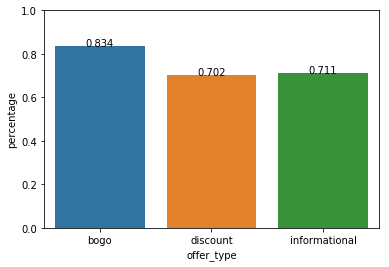

In [18]:
# bar chart showing view percentage by offer type
offer_type_percent = df.groupby('offer_type').apply(lambda x: x['viewed'].sum()/len(x)).to_frame().reset_index()
offer_type_percent.rename(columns={0: 'percentage'}, inplace=True)

import seaborn as sns
ax = sns.barplot(x='offer_type', y='percentage', data=offer_type_percent)
ax.set(ylim=(0, 1.0))

for index, row in offer_type_percent.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,3), color='black', ha='center')

[(0, 1.0)]

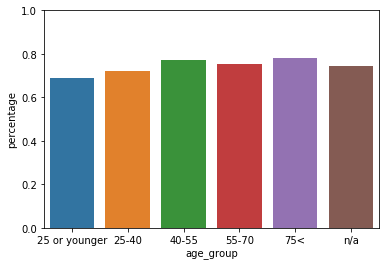

In [19]:
# bar chart showing view percentage by age group
age_percent = df.groupby('age_group').apply(lambda x: x['viewed'].sum()/len(x)).to_frame().reset_index()
age_percent.rename(columns={0: 'percentage'}, inplace=True)

ax = sns.barplot(x='age_group', y='percentage', data=age_percent)
ax.set(ylim=(0, 1.0))

[(0, 1.0)]

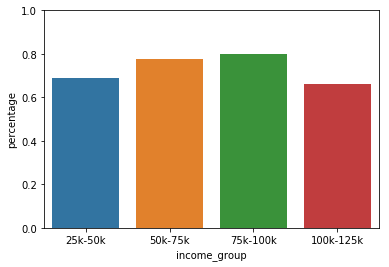

In [20]:
# bar chart showing view percentage by income group
income_percent = df.groupby('income_group').apply(lambda x: x['viewed'].sum()/len(x)).to_frame().reset_index()
income_percent.rename(columns={0: 'percentage'}, inplace=True)

ax = sns.barplot(x='income_group', y='percentage', data=income_percent, order=['25k-50k','50k-75k','75k-100k','100k-125k'])
ax.set(ylim=(0, 1.0))

In [21]:
# logistic regression model to predict who will view offer based on age, income, and days since joining

# drop rows with NaNs
data = df.dropna(subset=['age', 'income', 'time_difference'])

#create dataframe with the following fields
data = data[['age'
           ,'income'
           ,'time_difference'
           ,'viewed']] # extra predictor variables we can add later - 'Total Encounters (group)','days_since_last_appt_calc (group)',

X = data.loc[:, data.columns != 'viewed'] # create dataframe of predictor variables 
y = data.loc[:, data.columns == 'viewed'] # create dataframe of outcome variable(s)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # split up data into training and testing subsets

model = LogisticRegression(class_weight={1:1, 0:3}) # create model object
model.fit(X_train,y_train) # fit model to training data

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight={1: 1, 0: 3}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [23]:
def test_model(subset):
    """
    Description: 
      Tests logistic regression model on training or test data
    
    Parameters:
        subset (string) - can either be 'train' or 'test' depending on what subset
                          of the data the user wants to test
    
    Output:
        conf_matrix (array) - Confusion matrix that details true positives, false positives, 
                             true negatives and false positives
    """
    
    if subset.lower() == 'train':
    
        y_pred=model.predict(X_train) # create a list of predictions based on predictor variables
    
        y_true = y_train['viewed']
        # y_true = y_true.to_numpy()
        
        conf_matrix = confusion_matrix(y_true, y_pred) #, rownames=['Actual'], colnames=['Predicted'])
    
    else:

        y_pred=model.predict(X_test) # create a list of predictions based on predictor variables
        
        y_true = y_test['viewed']
        # y_true = y_true.to_numpy()
        
        conf_matrix = confusion_matrix(y_true, y_pred) #, rownames=['Actual'], colnames=['Predicted'])
        
    
    # Accuracy
    from sklearn.metrics import accuracy_score
    print('accuracy = '+ str(accuracy_score(y_true, y_pred)))
    print('\n')
    
    # Recall
    from sklearn.metrics import recall_score
    print('recall = '+ str(recall_score(y_true, y_pred)))
    print('\n')
    
    # Precision
    from sklearn.metrics import precision_score
    print('precision = '+ str(precision_score(y_true, y_pred)))
    print('\n')
    
    from sklearn.metrics import f1_score
    print('f1 = '+ str(f1_score(y_true, y_pred)))
    
    print('\n')
    print('Classification report:')
    print(classification_report(y_true, y_pred))
    print('\n')
    print('Model coefficients:')
    # print(model.coef_)
    # print(X.columns)
    
    temp = model.coef_.tolist()
    coefficient_list = [item for sublist in temp for item in sublist]
    dictionary = {'Variable':X.columns, 'Coefficient':coefficient_list}
    coefficients = pd.DataFrame(dictionary)
    print(coefficients)
    
    return(conf_matrix)

lr_conf_matrix = test_model('test')

accuracy = 0.602425943562


recall = 0.693625310674


precision = 0.753887712638


f1 = 0.722502099076


Classification report:
             precision    recall  f1-score   support

          0       0.27      0.33      0.30      5064
          1       0.75      0.69      0.72     14887

avg / total       0.63      0.60      0.62     19951



Model coefficients:
          Variable  Coefficient
0              age     0.001031
1           income     0.000001
2  time_difference    -0.000072


In [24]:
# random forest classifier to predict who will view offer based on age, income, and days since joining

from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               max_features='auto',
                               bootstrap=True,
                               random_state=42,
                               class_weight={1:1, 0:1})

# Fit on training data
model.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight={1: 1, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [26]:
def test_model(subset):
    """
    Description: 
      Tests random forest model on training or test data
    
    Parameters:
        subset (string) - can either be 'train' or 'test' depending on what subset
                          of the data the user wants to test
    
    Output:
        conf_matrix (array) - Confusion matrix that details true positives, false positives, 
                             true negatives and false positives
    """
    
    if subset.lower() == 'train':
    
        y_pred=model.predict(X_train) # create a list of predictions based on predictor variables
    
        y_true = y_train['viewed']
        # y_true = y_true.to_numpy()
        
        conf_matrix = confusion_matrix(y_true, y_pred) #, rownames=['Actual'], colnames=['Predicted'])
    
    else:

        y_pred=model.predict(X_test) # create a list of predictions based on predictor variables
        
        y_true = y_test['viewed']
        # y_true = y_true.to_numpy()
        
        conf_matrix = confusion_matrix(y_true, y_pred) #, rownames=['Actual'], colnames=['Predicted'])
    
    print('\n')
    print('Classification report:')
    print(classification_report(y_true, y_pred))
    print('#---------------')
    
    if subset.lower() == 'test':
        
    
        y_pred=model.predict(X_test) # create a list of predictions based on predictor variables
    
        y_true = y_test['viewed']
        # y_true = y_true.to_numpy()
        
        conf_matrix = confusion_matrix(y_true, y_pred) #, rownames=['Actual'], colnames=['Predicted'])
    
    else:

        y_pred=model.predict(X_test) # create a list of predictions based on predictor variables
        
        y_true = y_test['viewed']
        # y_true = y_true.to_numpy()
        
        conf_matrix = confusion_matrix(y_true, y_pred) #, rownames=['Actual'], colnames=['Predicted'])
    
    print('\n')
    print('Classification report:')
    print(classification_report(y_true, y_pred))
    print('#---------------')
    
    return(conf_matrix)


rf_conf_matrix = test_model('test')



Classification report:
             precision    recall  f1-score   support

          0       0.33      0.23      0.27      5064
          1       0.76      0.84      0.80     14887

avg / total       0.65      0.69      0.67     19951

#---------------


Classification report:
             precision    recall  f1-score   support

          0       0.33      0.23      0.27      5064
          1       0.76      0.84      0.80     14887

avg / total       0.65      0.69      0.67     19951

#---------------
